<a href="https://colab.research.google.com/github/hamidbekam9193-ui/Lectures/blob/main/M2_Networks_hands_on_in_python_25_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install holoviews # remove ! if you are not in Colab
# !pip install python-louvain # remove ! if you are not in Colab

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

# Introduction to Network Analysis

Welcome to your first part of the introduction to network analysis. In this session you will learn:

1. Why applying network analysis is helpful to answer certain questions, and why framing certain contexts as networks gives new insights.
2. The basic structure of relational data.
3. How to construct graph objects from different datasources.
4. How to analyse basic features of nodes, edges, and graphs.
5. How to identify groups and communities in graphs.
6. How to do simple network visualizations.

Generally, networks are a form of representing **relational data**. This is a very general tool that can be applied to many different types of relationships between all kind of elements. The content, meaning, and interpretation for sure depends on what elements we display, and which types of relationships. For example:

* In Social Network Analysis:
     * Nodes represent actors (which can be persons, firms and other socially constructed entities)
     * Edges represent relationships between this actors (friendship, interaction, co-affiliation, similarity ect.)
* Other types of network
     * Chemistry: Interaction between molecules
     * Computer Science: The wirld-wide-web, inter- and intranet topologies
     * Biology: Food-web, ant-hives

The possibilities to depict relational data are manifold. For example:

* Relations among persons
     * Kinship: mother of, wife of...
     * Other role based: boss of, supervisor of...
     * Affective: likes, trusts...
     * Interaction: give advice, talks to, retweets...
     * Affiliation: belong to same clubs, shares same interests...
* Relations among organizations
     * As corporate entities, joint ventures, strategic alliances
     * Buy from / sell to, leases to, outsources to
     * Owns shares of, subsidiary of
     * Via their members (Personnel flows, friendship...)

# Network data structures


## Edgelists
Most real world relational data is to be found in what we call an **edge list**, a dataframe that contains a minimum of two columns, one column of *nodes* that are the source of a connection and another column of nodes that are the target of the connection. The nodes in the data are identified by unique IDs.

If the distinction between source and target is meaningful, the network is **directed**. If the distinction is not meaningful, the network is **undirected** (more on that later). So, every row that contains the ID of one element in column 1, and the ID of another element in column 2 indicates that a connection between them exists.

An edge list can also contain additional columns that describe **attributes** of the edges such as a magnitude aspect for an edge. If the edges have a magnitude attribute the graph is considered **weighted** (e.g., number of interactions, strenght of friendship).


* Below an example of a minimal edge list created by zipping together two lists into a list of tuples.
* In this case, let us assume this network to be unweighted, meaning a connection can be eiter tresent or absent.


In [2]:
origin = [1, 2, 3, 1, 4, 5]
target = [2, 3, 4, 3, 5, 1]

In [3]:
edge_list = list(zip(origin, target))

print(edge_list)



[(1, 2), (2, 3), (3, 4), (1, 3), (4, 5), (5, 1)]


This can of cause also be a DataFrame where columns indicate origin and target

In [4]:
df = pd.DataFrame({'origin':origin, 'target':target})
df

,origin,target
0,1,2
1,2,3
2,3,4
3,1,3
4,4,5
5,5,1



## Adjacency Matrix

* A second popular form of network representation is the **adjacency-matrix** (also called **socio-matrix**).
* It is represented as a $n*n$ matrix, where $n$ stands for the number of elements of which their relationships should be represented.
* The value in the cell that intercepts row $n$ and column $m$ indicates if an edge is present (=1) or absent (=0).
* Tip: Given an edgelist, an adjacency matrix can easily be produced by crosstabulating:



In [5]:
mat_adj = pd.crosstab(df.origin, df.target)
mat_adj

target,1,2,3,4,5
origin,,,,,
1,0,1,1,0,0
2,0,0,1,0,0
3,0,0,0,1,0
4,0,0,0,0,1
5,1,0,0,0,0


In [6]:
from scipy import sparse

In [7]:
# CSR Matrix - Compressed Sparse matrix - showing adjacency matrix without zeros
df_adj_sparse = sparse.csr_matrix(mat_adj)
print(df_adj_sparse)

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 6 stored elements and shape (5, 5)>
  Coords	Values
  (0, 1)	1
  (0, 2)	1
  (1, 2)	1
  (2, 3)	1
  (3, 4)	1
  (4, 0)	1


## Nodelists
* Edgelists as well as adjacency matrices only stores connectivity pattern between nodes, but due to their structure cannot store informations on the nodes in which we might be interested.
* Therefore, we in many cases also provide a a **node list** with these informations (such as the names of the nodes or any kind of groupings).


In [8]:
name = ["Jesper", "Pernille", "Jacob", "Dorte", "Donald"]
sex = ["M", "F", "M", "F", "M"]
group = ["A", "B", "B", "A", "C"]

node_list = pd.DataFrame({'name':name, 'sex':sex, 'group':group})

In [9]:
node_list

,name,sex,group
0,Jesper,M,A
1,Pernille,F,B
2,Jacob,M,B
3,Dorte,F,A
4,Donald,M,C


## Graph Objects (NetworkX)

Up to now we see that relatonal data, and the analysis thereof, has some particularities, making it distinct from tabular data (e.g., dataframes), we usually work with.

#### **Why graph (relational) data is different from tabular data**

#### **Tabular data (e.g., dataframes)**

* Column stats depend on all rows: change one value and the **column’s (between observation)** mean, variance, etc. change.
* Within a row, variables can be related, so changing one may alter **row-level (within observation)** summaries (e.g., a total score).
* Otherwise, cells don’t force other cells to change—dependencies are limited.

#### **Graph (network) data**

* All of the above **plus** structural dependencies from relationships.
* Two interlinked layers: **nodes** and **edges**.
  Removing a node removes its incident edges; altering edges changes node properties (degree, neighbors, etc.).
* Changes can **ripple** through the network: adding/removing a single node or edge can affect paths, components, and many nodes’/edges’ metrics—not just immediate neighbors.
* Local measures (e.g., degree) are less sensitive; global measures (e.g., betweenness, shortest paths, clustering, connectivity) can shift dramatically.
* Hence, graph analysis needs its own algorithms and math—graph computing is inherently messier than simple table ops.


A graph object is a specific datastructure which contains node and edgelists jointly, and enables the application of graph algorithms on them. We in the following will work with the [`networkx`](https://networkx.github.io/documentation/stable/index.html) library, which is the standard for network analysis in the Python community. Another popular package more from the graph-theorist community is [`igraph`](https://igraph.org/python/), which is also the main package used for network analysis in the `R` community. However, since `networkx` became the `Python` standard, we will in the following stick to it.

In [10]:
import networkx as nx # Main network analysis library

In NetworkX, graph data are stored in a dictionary-like fashion.
They are placed under a `Graph` object,
canonically instantiated with the variable `G` as follows:

```python
G = nx.Graph()
```

Of course, you are free to name the graph anything you want!

Nodes are part of the attribute `G.nodes`.
There, the node data are housed in a dictionary-like container,
where the key is the node itself
and the values are a dictionary of attributes.
Node data are accessible using syntax that looks like:

```python
G.nodes[node1]
```

Edges are part of the attribute `G.edges`,
which is also stored in a dictionary-like container.
Edge data are accessible using syntax that looks like:

```python
G.edges[node1, node2]
```
Because of the dictionary-like implementation of the graph,
any hashable object can be a node.
This means strings and tuples, but not lists and sets.

### Types of Graphs


1. Weigthed vs. Unweighted
2. Directed vs. Undirected
3. Unimodal vs. Multimodal
4. Unidimensional vs. Multidimensional

`networkx` graph classes
1. Graph
2. DiGraph
3. MultiGraph
4. MultiDigraph

### Creating a graph object

The graph object forms the core of network analysis. This is the central place where nodes, edges, and their characteristics are jointly stored. Lets take a look how to create one.

In [11]:
# We can create a network graph G directly from the adjacency matrix.
G = nx.from_numpy_array(df_adj_sparse)
print(G.nodes(), G.edges())

[0, 1, 2, 3, 4] [(0, 1), (0, 2), (0, 4), (1, 2), (2, 3), (3, 4)]


In [12]:
# We can also directly load an edgelist instead
G = nx.from_edgelist(edge_list)
print(G.nodes(), G.edges())

[1, 2, 3, 4, 5] [(1, 2), (1, 3), (1, 5), (2, 3), (3, 4), (4, 5)]


In [13]:
# We can also create an own graph
G = nx.Graph() # create an empty graph with no nodes and no edges
print(G.nodes(), G.edges())

[] []


In [14]:
G.add_nodes_from([1, 2, 3, 4, 5]) # add a list of nodes
G.add_edges_from([(1,2), (1,3), (4,5), (5,3), (4,2), (3,2), (1,4)]) # add a list of edges
print(G.nodes(), G.edges())

[1, 2, 3, 4, 5] [(1, 2), (1, 3), (1, 4), (2, 4), (2, 3), (3, 5), (4, 5)]


Ok, up to now that was pretty abstract, right? Lets plot the graph to get a feeling what the network looks like. We will explore this later more exhaustive.

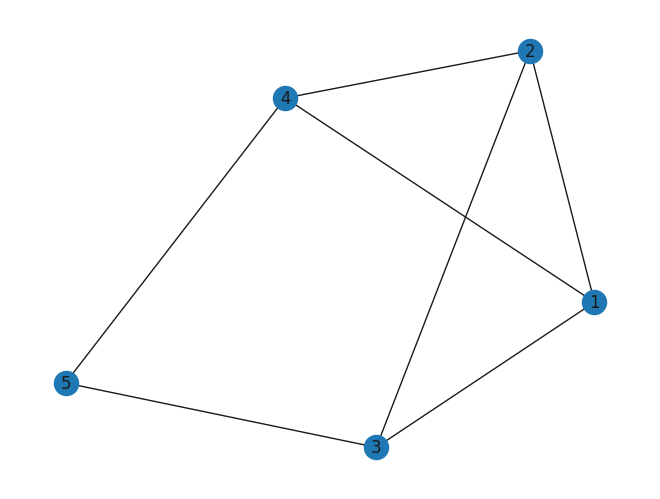

In [15]:
nx.draw(G, with_labels=True)


### Your turn!

So, now its already time for a little exercise: Try to create and plot the following network structure. Have fun :)

![](https://www.dropbox.com/s/88anz0w24kurckp/networks_mini_exercise.png?dl=1)

### Node Attributes


In [16]:
G = nx.from_edgelist([('Jesper', 'Pernille'), ('Jesper', 'Donald'), ('Jesper', 'Dorte'), ('Pernille', 'Jacob'), ('Pernille', 'Dorte')])

We can also include the node attributes in the graph object

In [17]:
# Graph objects are dictionaries, so attributes need to be dictionaries too. They are matched via the index (=node name/id)
node_attr = node_list.set_index('name').to_dict('index')

node_attr

{'Jesper': {'sex': 'M', 'group': 'A'},
 'Pernille': {'sex': 'F', 'group': 'B'},
 'Jacob': {'sex': 'M', 'group': 'B'},
 'Dorte': {'sex': 'F', 'group': 'A'},
 'Donald': {'sex': 'M', 'group': 'C'}}

In [18]:
# set node attributes
nx.set_node_attributes(G, node_attr)

In [19]:
# view nodes with attributes
G.nodes(data=True)

NodeDataView({'Jesper': {'sex': 'M', 'group': 'A'}, 'Pernille': {'sex': 'F', 'group': 'B'}, 'Donald': {'sex': 'M', 'group': 'C'}, 'Dorte': {'sex': 'F', 'group': 'A'}, 'Jacob': {'sex': 'M', 'group': 'B'}})

In [20]:
G.edges()

EdgeView([('Jesper', 'Pernille'), ('Jesper', 'Donald'), ('Jesper', 'Dorte'), ('Pernille', 'Jacob'), ('Pernille', 'Dorte')])

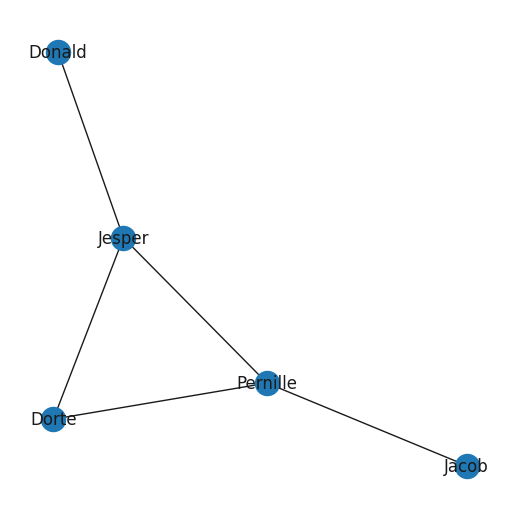

In [21]:
# First (not pretty) visualization
plt.figure(figsize=(5,5))
nx.draw_kamada_kawai(G, with_labels = True)

In [22]:
# Node characteristics
G.nodes()['Jesper']

{'sex': 'M', 'group': 'A'}

In [23]:
# Node and adjacencies
G['Jesper']

AtlasView({'Pernille': {}, 'Donald': {}, 'Dorte': {}})

In [24]:
# Conditional node selection
node_list[node_list.sex == 'F'].name

,name
1,Pernille
3,Dorte


In [25]:
# subsetting
G_sub = nx.subgraph(G, node_list[node_list.sex == 'F'].name)

# Network analysis and measures

**European Patent Office inventor**

This dataset is a cleaned extract of European Patent Office inventor records where **each row links an inventor to a single patent application**: `appln_id` is the application identifier, `person_id` is the inventor’s stable ID, and `inv_name` is the inventor’s name string. Because one application can list multiple inventors (and one inventor can appear on many applications), the table is inherently many-to-many and is well-suited for building **co-inventor networks** by grouping rows on `appln_id` and pairing the associated `person_id`/`inv_name` values. In practice you’ll often `drop_duplicates(['appln_id','person_id'])` to remove any repeat lines for the same person–application combination and use `person_id` (not just `inv_name`) as the reliable key when aggregating or matching inventors.


<img src="https://ficpi.org/system/files/styles/event_image/private/2024-07/EPO-European-Inventor-Award-Logo.jpg" alt="Image" width="300">




In [26]:
df = pd.read_csv('https://raw.githubusercontent.com/hamidb201214-svg/Lectures/refs/heads/main/data/epo_inventors_clean.csv', low_memory=False, encoding='latin-1')
df[['appln_id','person_id', 'inv_name']].head(10)

,appln_id,person_id,inv_name
0,524471176,69775855,"VENDELBO, Allan Munk"
1,524471215,69746744,"BRÃDSGAARD, Martin"
2,524471215,74442350,"SÃRENSEN, SÃ¸ren Hove"
3,524471215,79429609,"YVES DEBRUYNE, Yannick"
4,524471215,79475544,"SEAWARD, James"
5,524593647,79351324,"Ponnada, Sri Markandeya Rajesh"
6,524645416,79328390,"Jul Jacobsen, Niels"
7,524645416,79340468,"Haagaard, Oliver"
8,524645416,79340481,Lindskov Naundrup-Jensen
9,524645416,79496834,"Bjergskov Nielsen, Mikkel"


## 2. From table to network

**Definition**  
- **Nodes**: Inventors (`inv_name`)  
- **Edges**: Undirected ties between inventors who appear on the same `appln_id`  

We’ll build both an **unweighted** graph (edge exists if co‑invented at least once) and a **weighted** graph (edge weight = number of shared applications).


In [27]:
df[df["person_id"] == 81614534]

,app_nbr,appln_id,pub_nbr,person_id,inv_name,address,city,postal_code,reg_code,ctry_code,reg_share,inv_share
2448,EP20210167659,548794423,3902285,81614534,"PEDERSEN, Michael Syskind",DK-2765 SmÃ¸rum,Smorum,2765,DK013,DK,1,0.100000
2804,EP20210173042,550313951,3917168,81614534,"PEDERSEN, Michael Syskind",DK-2765 SmÃ¸rum,Smorum,2765,DK013,DK,1,0.083333
3377,EP20210181843,552947681,3934278,81614534,"PEDERSEN, Michael Syskind",DK-2765 SmÃ¸rum,Smorum,2765,DK013,DK,1,0.142857
3437,EP20210182124,553031434,3934279,81614534,"PEDERSEN, Michael Syskind",DK-2765 SmÃ¸rum,Smorum,2765,DK013,DK,1,0.100000
4506,EP20210199395,558169455,3979666,81614534,"PEDERSEN, Michael Syskind",DK-2765 SmÃ¸rum,Smorum,2765,DK013,DK,1,0.200000
4863,EP20210204737,559396381,4007308,81614534,"PEDERSEN, Michael Syskind",DK-2765 SmÃ¸rum,Smorum,2765,DK013,DK,1,0.250000
4873,EP20210205003,559559697,3998779,81614534,"PEDERSEN, Michael Syskind",DK-2765 SmÃ¸rum,Smorum,2765,DK013,DK,1,0.083333


In [28]:
import pandas as pd
import numpy as np
from scipy import sparse
import networkx as nx
from scipy.sparse import csr_matrix
from sklearn.preprocessing import LabelEncoder

# Build categorical codes for compact integer indices
le_pid = LabelEncoder().fit(df["inv_name"])
le_app = LabelEncoder().fit(df["appln_id"])

pid_codes = le_pid.transform(df["inv_name"])   # 0..P-1
app_codes = le_app.transform(df["appln_id"])    # 0..A-1

# 1) Sparse inventor × application incidence (binary)
xt = pd.crosstab(df['inv_name'], df['appln_id'])

# make it binary (if duplicates exist)
xt = (xt > 0).astype(pd.SparseDtype(np.uint8, fill_value=0))

# convert to SciPy sparse (COO) then CSR
X = xt.sparse.to_coo().tocsr()

In [29]:
# 2) Co-occurrence adjacency (sparse)
A = X @ X.T
# sets the main diagonal of A to zero in place
A.setdiag(0)
A.eliminate_zeros()

In [30]:
# 3) Convert to weighted edge list
u, v = A.nonzero()
w = A.data
edges = pd.DataFrame({
    "person_id_u": le_pid.classes_[u],
    "person_id_v": le_pid.classes_[v],
    "weight": w
})

# keep only one direction (u < v) to avoid duplicates
edges = edges[edges["person_id_u"] < edges["person_id_v"]].reset_index(drop=True)

# 4) Build graphs
G  = nx.Graph()
G.add_edges_from(zip(edges["person_id_u"], edges["person_id_v"]))  # unweighted

GW = nx.Graph()
GW.add_weighted_edges_from(edges[["person_id_u", "person_id_v", "weight"]].itertuples(index=False, name=None))

print(f"Unweighted: nodes={G.number_of_nodes()} edges={G.number_of_edges()}")
print(f"Weighted:   nodes={GW.number_of_nodes()} edges={GW.number_of_edges()}")

Unweighted: nodes=3410 edges=7632
Weighted:   nodes=3410 edges=7632


In [31]:
# a basic information about the graph
print(f"Graph info:")
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
print(f"Graph is directed: {G.is_directed()}")
print(f"Node list: {list(G.nodes())[:10]}")  # Display first 10 nodes
print(f"Edge list: {list(G.edges())[:10]}")

Graph info:
Number of nodes: 3410
Number of edges: 7632
Graph is directed: False
Node list: ['AABJERG, Mia', 'ZHURAVLOV, Pavel', 'AABO, Olav', 'Stubkier, Simon', 'AABOE, ThorbjÃ¸rn', 'OLESEN, Bent Ekfeldt', 'AASBERG-PETERSEN, Kim', 'CHRISTENSEN, Sandahl Thomas', 'MORTENSEN, Peter MÃ¸lgaard', 'DE SARKAR, Sudip']
Edge list: [('AABJERG, Mia', 'ZHURAVLOV, Pavel'), ('ZHURAVLOV, Pavel', 'BERKEL, Alex'), ('ZHURAVLOV, Pavel', 'BRINK, Morten Bak'), ('ZHURAVLOV, Pavel', 'NIELSEN, Michael Wenani'), ('ZHURAVLOV, Pavel', 'PANDARINATH, Suresh Babu Gangavaram'), ('ZHURAVLOV, Pavel', 'PUJARI, Pragneshbhai Vijay Kumar'), ('ZHURAVLOV, Pavel', 'SHARMA, Sheetu'), ('AABO, Olav', 'Stubkier, Simon'), ('AABOE, ThorbjÃ¸rn', 'OLESEN, Bent Ekfeldt'), ('AASBERG-PETERSEN, Kim', 'CHRISTENSEN, Sandahl Thomas')]


In [32]:
import networkx as nx
import matplotlib.pyplot as plt

TOP_N = 200

# 1) pick top 100 nodes by degree (or fewer if graph is small)
deg = dict(G.degree())
top_nodes = [n for n, _ in sorted(deg.items(), key=lambda x: x[1], reverse=True)[:TOP_N]]

# 2) induce the subgraph and (optionally) keep only the largest connected component
H = G.subgraph(top_nodes).copy()
if H.number_of_nodes() and H.number_of_edges():
    largest = max(nx.connected_components(H), key=len)
    H = H.subgraph(largest).copy()


### Basic graph info


- **Number of nodes:** Counts how many unique entities (vertices) are in the graph, i.e., the size of the node set.
- **Number of edges:** Counts how many connections (undirected links) exist between nodes, i.e., the size of the edge set.
- **Graph is directed:** Tells you whether edges have an inherent direction (True) or are undirected (False).
- **Node list:** Shows a small sample (first three) of node IDs so you can see how nodes are labeled.
- **Edge list:** Shows a small sample (first three) of edges as node pairs so you can see how connections are represented.

Lets take a first visual peek. For a non-trivial (not like the one before) visualization of networks, the way how nodes and edges are placed in the plot makes a big difference in terms of how informative the visualization is, and how much information we can get out of it.

There are plenty of different algorithms to optimize node and edge positions in visualizations within a graph **layout**. [Here](https://networkx.github.io/documentation/stable/reference/drawing.html#module-networkx.drawing.layout) you find an overview over the ones implemented in `networkx`.

We can usually render these layouts on the fly when plotting the graph object. Since these algorithms contain probabilistic and iterative elements, they might look slightly different from plot to plot, though. Since we will plot this network a couple of times during this tutorial and want to compare them among each others, we will create and save the layout already upfront and pass it every time to the plotting function to make sure that the nodes are always placed in the same position.

Here, we use the *Fruchterman-Reingold* algorithm-one of the most commonly used ones-to create the layout.

In [33]:
# Create and save a layout.
H_layout = nx.layout.fruchterman_reingold_layout(H)

/usr/local/lib/python3.12/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 129 (\x81) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129 (\x81) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


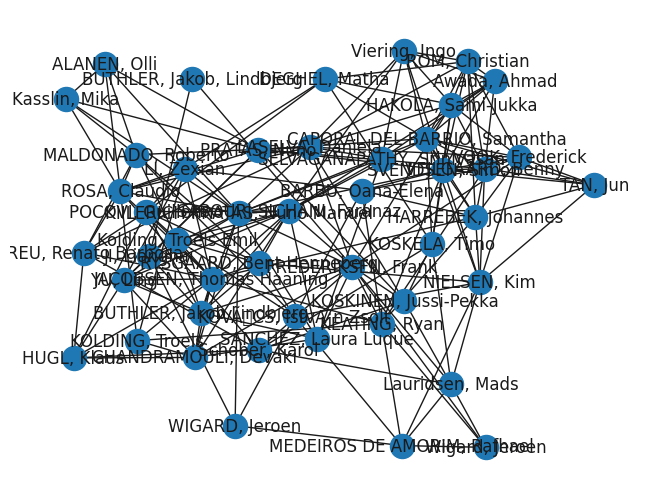

In [34]:
# We use the standard networkx plot, and pass the layout.
nx.draw(H, pos = H_layout, with_labels=True)

Well, we somewhat an intuition of the network architecture, containing a core-region, and some periphral centers. Otherwise, it's rather uninformative. Good network visualization after all is more than just doing a standard plot, so there is much we can do to make it more informative. However, we get to that later.

In this case, we have a weighted graph, meaning that an edge does not only exist or not, (binary), but rather weighted by the number of the nodes (representing characters) interaction.

In this case, we have a weighted graph, meaning that an edge does not only exist or not, (binary), but rather weighted by the number of the nodes (representing characters) interaction.

In [66]:
nx.get_edge_attributes(GW, 'weight')

We see that the edge weights vary quite a lot. For this simple example we will remove the weights to give us a undirected and unweighted graph.

In [36]:
for n1, n2, d in G.edges(data=True):
  d.pop('weight', None)

We can even do better! We can use the powerful [`bokeh`](https://docs.bokeh.org/) library (we installed it in the preamble). However, it is very clunky to work with. The [`hollowviews`](http://holoviews.org/user_guide/Network_Graphs.html) library in turn provides a lightweight wrapper that enables us to produce pretty interactive visualizations with a few lines of code. Lets do that!

PS: Try to hover over the nodes :-)

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
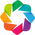

In [37]:
# Import the libraries and link to the bokeh backend
import holoviews as hv
from holoviews import opts
hv.extension('bokeh')
from bokeh.plotting import show

# Setting the default figure size a bit larger
defaults = dict(width=750, height=750, padding=0.1,
                xaxis=None, yaxis=None)
hv.opts.defaults(
    opts.EdgePaths(**defaults), opts.Graph(**defaults), opts.Nodes(**defaults))

In [38]:
g_plot = hv.Graph.from_networkx(H, H_layout).opts(tools=['hover'])

In [39]:
show(hv.render(g_plot))

## Node-Level measures

Often, we are interested in ways to summarize the pattern of node connectivity to infer something on their characteristics.


## Node-Level measures

Often, we are interested in ways to summarize the pattern of node connectivity to infer something on their characteristics.

One of the simplest concepts when computing node level measures is that of **centrality**, i.e. how central is a node or edge in the graph. As this definition is inherently vague, a lot of different centrality scores exists that all treat the concept of "central" a bit different.

We in the following well briefly illustrate the idea behind three of the most popular centrality measures, namely:

* Degree centrality: How many other nodes a node is directly connected to (e.g., how many co-inventors someone has)
* Eigenvector centrality: A node is important if it connects to other important nodes—its score increases when its neighbors also have high scores (recursive popularity).
* Betweenness centrality: How often a node sits on shortest paths between other nodes, indicating its role as a bridge or broker.

### Degree centrality
The degree centrality is probably the most intuitive node measure, which basically just counts the number of edges adjacent to a node.  Formally, the degree of node $i$ is the number of existing edges $e_{ij}$ with other nodes $j$ in a network with $n$ nodes:

$$d_{ij} =\sum\limits_{j=1}^{n} e_{ij} ~ where: ~ i \neq j$$

In [40]:
cent_degree = dict(nx.degree(H))

In [41]:
list(cent_degree.values())[:10]

[7, 15, 14, 4, 9, 5, 11, 6, 8, 10]

In [42]:
top10 = sorted(cent_degree.items(), key=lambda x: x[1], reverse=True)[:10]
top10

[('KIILERICH PRATAS, Nuno Manuel', 16),
 ('SABOURI-SICHANI, Faranaz', 15),
 ('CAPORAL DEL BARRIO, Samantha', 15),
 ('SVENDSEN, Simon', 15),
 ('FREDERIKSEN, Frank', 14),
 ('JACOBSEN, Thomas Haaning', 14),
 ('LASELVA, Daniela', 12),
 ('VEJLGAARD, Benny', 12),
 ('HAKOLA, Sami-Jukka', 11),
 ('BUTHLER, Jakob Lindbjerg', 11)]

Here’s a compact readout of your top 10 inventors by the chosen network score (e.g., degree/weighted co-inventor ties): the name is the inventor and the number is their score—higher means more central/connected in the co-inventor network. In this run, Nuno Manuel Kiilerich Pratas (16) ranks first, followed by Samantha Caporal del Barrio (15), Faranaz Sabouri-Sichani (15), and Simon Svendsen (15); next come Thomas Haaning Jacobsen (14) and Frank Frederiksen (14), with Daniela Laselva (12) and Benny Vejlgaard (12), then Jakob Lindbjerg Buthler (11) and Sami-Jukka Hakola (11) completing the top 10—indicating these researchers collaborate broadly and/or act as key hubs within the co-inventor network.

In [43]:
nx.set_node_attributes(H, cent_degree, 'cent_degree')

g_plot = hv.Graph.from_networkx(H, H_layout).opts(tools=['hover'],
                                                  node_size='cent_degree')

show(hv.render(g_plot))

In [44]:
nx.get_node_attributes(H,'cent_degree')

{'KOVÃ\x81CS, IstvÃ¡n Zsolt': 7,
 'SABOURI-SICHANI, Faranaz': 15,
 'FREDERIKSEN, Frank': 14,
 'Wigard, Jeroen': 4,
 'POCOVI, Guillermo': 9,
 'ALANEN, Olli': 5,
 'HAKOLA, Sami-Jukka': 11,
 'KOSKINEN, Jussi-Pekka': 6,
 'Viering, Ingo': 8,
 'HARREBEK, Johannes': 10,
 'LASELVA, Daniela': 12,
 'Kolding, Troels Emil': 7,
 'MALDONADO, Roberto': 8,
 'SELVAGANAPATHY, Srinivasan': 6,
 'ABREU, Renato Barbosa': 7,
 'CHANDRAMOULI, Devaki': 9,
 'CAPORAL DEL BARRIO, Samantha': 15,
 'BUTHLER, Jakob Lindbjerg': 11,
 'ROSA, Claudio': 11,
 'Awada, Ahmad': 8,
 'HUGL, Klaus': 6,
 'DEGHEL, Matha': 6,
 'KIILERICH PRATAS, Nuno Manuel': 16,
 'ROM, Christian': 10,
 'PRATAS, Nuno': 10,
 'KOLDING, Troels': 5,
 'Lauridsen, Mads': 7,
 'YU, Ling': 9,
 'Schober, Karol': 7,
 'SVENDSEN, Simon': 15,
 'KOSKELA, Timo': 7,
 'SANCHEZ, Laura Luque': 6,
 'BARBU, Oana-Elena': 6,
 'JACOBSEN, Thomas Haaning': 14,
 'MEDEIROS DE AMORIM, Rafhael': 6,
 'NIELSEN, Kim': 10,
 'VEJLGAARD, Benny': 12,
 'VOOK, Frederick': 10,
 'WIGARD, Je

### Degree vs. Weighted Degree vs. “Strength per Partner”

- **Degree** = number of distinct collaborators.
- **Weighted degree (strength)** = total repeated collaborations across all partners.
- **Strength per partner** = weighted_degree ÷ degree (average repeats with each collaborator).


In [45]:
import pandas as pd

# 1) compute degree (partners count) and weighted degree (sum of weights)
deg  = pd.Series(dict(G.degree()), name="degree")
wdeg = pd.Series({n: sum(d.get("weight", 1) for _,_,d in GW.edges(n, data=True))
                  for n in GW.nodes()}, name="weighted_degree")

stats = pd.concat([deg, wdeg], axis=1).fillna(0).astype(int)

# 2) find “few partners but many repeats”: high weighted_degree with small degree
stats["strength_per_partner"] = (stats["weighted_degree"] / stats["degree"].replace(0, 1))
examples = (stats[stats["degree"].between(1, 3)]
            .sort_values(["weighted_degree","strength_per_partner"], ascending=False)
            .head(10))
examples

,degree,weighted_degree,strength_per_partner
"Cerda Varela, Alejandro",3,18,6.000000
"AHRENFELDT, Jesper",3,12,4.000000
"HENRIKSEN, Ulrik Birk",3,12,4.000000
"Hald, Flemming",3,12,4.000000
"Markussen, Torben",3,12,4.000000
"Kielgast, Mathias RÃ¸nholt",3,12,4.000000
"Hofni, Jeppe",3,12,4.000000
"HANSEN, Marie Bendix",3,11,3.666667
"LINDVED, Bodil KjÃ¦r",3,11,3.666667
"LIHME, Allan Otto Fog",3,11,3.666667


**Interpretation:**
- Everyone listed has **degree = 3** (exactly three distinct collaborators).
- They differ in **how often** they co-invent with those collaborators:
  - **Cerda Varela, Alejandro** stands out: **18 total co-applications** with just 3 partners ⇒ **6 on average per partner**.  
    *Pattern:* very tight, repeated teamwork with a small circle.
  - The group with **weighted_degree = 12** averages **4 per partner**—still strong, but less concentrated than 6.
  - The **11 / 3.67** group suggests slightly fewer repeats per partner than the “12 / 4” group.

**Takeaway:** Counting partners (degree) alone hides intensity; **strength per partner** reveals who forms **deep, durable ties** vs. broader, lighter ties.

This mini-case shows why breadth and depth of collaboration aren’t the same: although every inventor listed has the same degree (three distinct collaborators), their weighted degree (total repeated co-applications) and thus strength per partner (weighted_degree ÷ degree) differ sharply, revealing how intensely they work with that small circle; for example, Cerda Varela, Alejandro has 18 total co-applications with three partners—an average of 6 per partner—signaling a tight, durable core team, while others at 12 (≈4 per partner) or 11 (≈3.67 per partner) still show strong but less concentrated ties; the takeaway for students is that counting partners alone can hide crucial structure—strength per partner highlights who operates as a deep specialist within a stable team versus those spreading effort more evenly across collaborators, with implications for project efficiency, innovation style, and resilience.

### Eigenvector centrality
Similar to the degree centrality, the eigenvector centrality takes this idea of characterizing nodes by their importance in a network a step further. It also represents the main idea behind the pagerank algorithm (a variant of eigenvector centrality) that was powering Google Search in the beginning.

The basic idea is to weight a node's degree centrality by the centrality of the nodes adjacent to it (and their centrality in turn by their centrality). This will make nodes connected to in turn also well connected nodes more important. The eigenvector here is just a clever mathematical trick to solve such a recurrent problem.

$$x_{v}={\frac {1}{\lambda }}\sum _{t\in M(v)}x_{t}={\frac {1}{\lambda }}\sum _{t\in G}a_{v,t}x_{t}$$

In [46]:
cent_eigen = dict(nx.eigenvector_centrality(H))

In [47]:
top10 = sorted(cent_eigen.items(), key=lambda x: x[1], reverse=True)[:10]
top10

[('CAPORAL DEL BARRIO, Samantha', 0.28087844622977176),
 ('SVENDSEN, Simon', 0.27125387093453446),
 ('KIILERICH PRATAS, Nuno Manuel', 0.23876302405560598),
 ('SABOURI-SICHANI, Faranaz', 0.23537598482980204),
 ('VEJLGAARD, Benny', 0.22393805015758825),
 ('HAKOLA, Sami-Jukka', 0.21380691130994814),
 ('VOOK, Frederick', 0.20763284324092487),
 ('ROM, Christian', 0.20330851846795445),
 ('FREDERIKSEN, Frank', 0.19545485240350324),
 ('HARREBEK, Johannes', 0.19104035959160584)]

In [48]:
for  i in cent_eigen:
  cent_eigen[i] = cent_eigen[i]*100

In [49]:
nx.set_node_attributes(H, cent_eigen, 'cent_eigen')

g_plot = hv.Graph.from_networkx(H, H_layout).opts(tools=['hover'],
                                                  node_size='cent_eigen' )

show(hv.render(g_plot))

,name,degree,weighted_degree,eigenvector
"HIGSON, Lee","HIGSON, Lee",2,2,0.002657


,name,degree,weighted_degree,eigenvector
"Clausen, Anders Ãstergaard","Clausen, Anders Ãstergaard",5,7,5.704488e-23


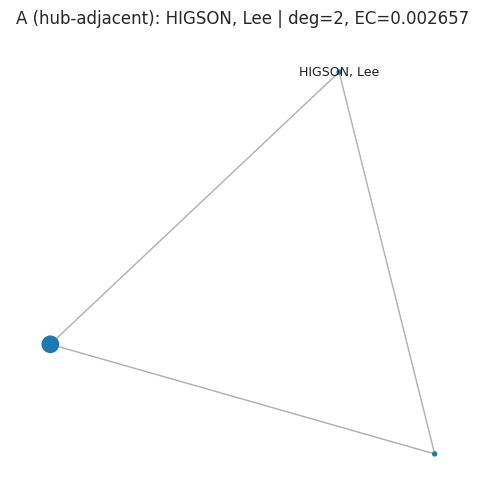

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 152 (\x98) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


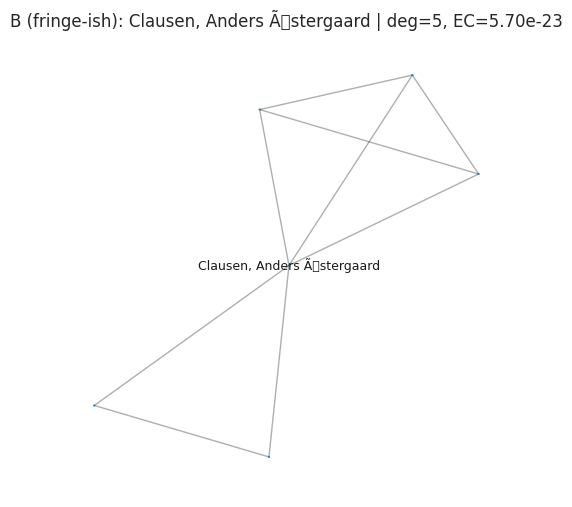

In [50]:
# Quick ego plots for A and B (node size ~ eigenvector centrality, label = name)

import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

# --- 0) (optional) id → name map for nicer printing ---
name_map = (df[['person_id','inv_name']].dropna()
                  .groupby('person_id')['inv_name']
                  .agg(lambda s: s.value_counts().idxmax())
                  .to_dict())
def name_of(n): return name_map.get(n, str(n))

# --- 1) compute basics on your existing graphs G (unweighted) and GW (weighted) ---
deg  = pd.Series(dict(G.degree()), name="degree")
# weighted degree (strength), in case you want it for context:
wdeg = pd.Series({n: sum(d.get("weight", 1) for _,_,d in GW.edges(n, data=True))
                  for n in GW.nodes()}, name="weighted_degree")

# eigenvector centrality: unweighted (use weighted version by adding weight="weight" on GW)
ec = pd.Series(nx.eigenvector_centrality(G, max_iter=2000), name="eigenvector")

stats = pd.concat([deg, wdeg, ec], axis=1).fillna(0)
stats["name"] = [name_of(n) for n in stats.index]

# --- 2) pick two contrasting examples ---
# A: small degree (<=2 or 3) but *high* eigenvector (top by EC among small-degree nodes)
cand_A = (stats[stats["degree"].between(1, 3)]
          .sort_values("eigenvector", ascending=False)
          .head(1))

# B: larger degree (>=5) but *low* eigenvector
cand_B = (stats[stats["degree"] >= 5]
          .sort_values("eigenvector", ascending=True)
          .head(1))

display(cand_A[["name","degree","weighted_degree","eigenvector"]])
display(cand_B[["name","degree","weighted_degree","eigenvector"]])
def ego_plot(G, stats, node, title):
    Ego = nx.ego_graph(G, node, radius=1)
    pos = nx.spring_layout(Ego, seed=7)
    sizes = [3000 * float(stats.loc[n, "eigenvector"] + 1e-4) for n in Ego.nodes()]  # avoid zeros
    labels = {n: stats.loc[n, "name"] if n == node else "" for n in Ego.nodes()}

    plt.figure(figsize=(6,6))
    nx.draw_networkx_nodes(Ego, pos, node_size=sizes)
    nx.draw_networkx_edges(Ego, pos, alpha=0.35)
    nx.draw_networkx_labels(Ego, pos, labels=labels, font_size=9)
    plt.title(title)
    plt.axis("off")
    plt.show()

if len(cand_A):
    nA = cand_A.index[0]
    ego_plot(G, stats, nA, f"A (hub-adjacent): {stats.loc[nA,'name']} | deg={int(stats.loc[nA,'degree'])}, EC={stats.loc[nA,'eigenvector']:.4g}")

if len(cand_B):
    nB = cand_B.index[0]
    ego_plot(G, stats, nB, f"B (fringe-ish): {stats.loc[nB,'name']} | deg={int(stats.loc[nB,'degree'])}, EC={stats.loc[nB,'eigenvector']:.2e}")


### Betweenness centrality

* The betweenness centrality of an object in a network measures the extent to which it lies on short paths
* A higher betweenness indicates that it lies on more short paths and hence should somehow be important for traversing between different parts of a network
* How many pairs of individuals would have to go through you in order to reach one another in the minimum number of hops? Who has higher betweenness, X or Y?

In formulaic representation

* The geodesic betweenness $B_{n}(i)$ of a **vertex** in a weighted, undirected network is
$$B_{n}(i) =  \sum_{s,t \in G} \frac{ \Psi_{s,t}(i) }{\Psi_{s,t}}$$
where vertices $s,t,i$ are all different from each other

* $\Psi_{s,t}$ denotes the number of shortest paths (geodesics) between vertices $s$ and $t$
* $\Psi_{s,t}(i)$ denotes the number of shortest paths (geodesics) between vertices $s$ and $t$ **that pass through vertex** $i$.
* The geodesic betweenness $B_n$ of a network is the mean of $B_n(i)$ over all vertices $i$

In [51]:
cent_between = nx.betweenness_centrality(H)
top10 = sorted(cent_between.items(), key=lambda x: x[1], reverse=True)[:10]
top10

[('FREDERIKSEN, Frank', 0.11339846263197419),
 ('KIILERICH PRATAS, Nuno Manuel', 0.10989031500617955),
 ('SABOURI-SICHANI, Faranaz', 0.07339824580911923),
 ('JACOBSEN, Thomas Haaning', 0.06051688070627463),
 ('LASELVA, Daniela', 0.05978588174220975),
 ('CAPORAL DEL BARRIO, Samantha', 0.05555776657158117),
 ('SVENDSEN, Simon', 0.054165039918159345),
 ('PRATAS, Nuno', 0.04650976128248855),
 ('KEATING, Ryan', 0.04259519801186467),
 ('NIELSEN, Kim', 0.03949343866010532)]

In [52]:
for  i in cent_between:
  cent_between[i] = cent_between[i]*100

In [53]:
nx.set_node_attributes(H, cent_between, 'cent_between')

g_plot = hv.Graph.from_networkx(H, H_layout).opts(tools=['hover'],
                                                  node_size='cent_between' )

show(hv.render(g_plot))

## Neighborhood of a Node

Further, we can look at the surrounding of a node, meaning the ones it is connected to, its **neighborhood**. Here, we can look at the **ego-network of a node**. That means how many nodes are in a certain **geodesic distance**, meaning the **shortest path**. Plainly speaking, how many nodes are not more than x-steps away.

![](https://www.dropbox.com/s/yat7qsdfszmc1d1/networks_distance.jpg?dl=1)




In [54]:
path = list(nx.all_shortest_paths(G, source="FREDERIKSEN, Frank", target="NIELSEN, Kim"))
print(path)

[['FREDERIKSEN, Frank', 'VOOK, Frederick', 'NIELSEN, Kim'], ['FREDERIKSEN, Frank', 'Lauridsen, Mads', 'NIELSEN, Kim']]


In [55]:
print(list(G.neighbors("FREDERIKSEN, Frank")))

['BUTHLER, Jakob', 'BUTHLER, Jakob Lindbjerg', 'BUTHLER, Jakob, Lindbjerg', 'CHANDRAMOULI, Devaki', 'DALSGAARD, Lars', 'KOVÃ\x81CS, IstvÃ¡n, Z.', 'KEATING, Ryan', 'SAINI, Jitendra, Kumar', 'RAVEENDRAN, Sharath', 'LIU, Ziqi', 'KOSKINEN, Jussi-Pekka', 'VOOK, Frederick', 'HAKOLA, Sami-Jukka', 'Schober, Karol', 'KAIKKONEN, Jorma Johannes', 'Hooli, Kari Juhani', 'Wigard, Jeroen', 'RATASUK, Rapeepat', 'Lauridsen, Mads', 'SAINI, Jitendra Kumar', 'PEETHAMBARAN NAIR RAJALAKSHMI, Nandagopal', 'KUMAR, Nanda', 'KRISHNE GOWDA, Kishore', 'KANAVALLI, Sambhram', 'LASELVA, Daniela', 'KIILERICH PRATAS, Nuno Manuel', 'SANCHEZ, Laura Luque', 'SABOURI-SICHANI, Faranaz', 'PRATAS, Nuno Kiilerich']


In [56]:
len(list(G.neighbors("FREDERIKSEN, Frank")))

29

In [57]:
def neighborhood(G, node, n):
    path_lengths = nx.single_source_dijkstra_path_length(G, node)
    return [node for node, length in path_lengths.items()
                    if length == n]

In [58]:
len(neighborhood(G, 'FREDERIKSEN, Frank', 2))

99

# Network-Level Measures

Finally, it is often also informative to look at the overall characteristics of the network.

*   **Modularity (for community detection):** Measures how much more densely connected nodes are within groups than expected by chance—higher means clearer community structure.

*   **Graph Density:** The fraction of possible edges that actually exist—higher means a more tightly connected network.

*   **Graph Transitivity (Global Clustering):** The share of two-hop connections that close into triangles—higher means more cohesive, triangle-rich structure.

*   **Diameter:** The longest shortest-path between any two nodes—smaller diameters imply information can spread quickly.

*   **Mean Distance (Average Path Length):** The average shortest-path length over all node pairs—lower values indicate more efficient connectivity overall.

# Modularity Score for Community Detection

Modularity scores a grouping of nodes by asking: “Are there more connections inside each group than we’d expect by random chance (given node popularity)?”

We compare the actual links inside groups ($A_{ij}$) to the expected links from a null model ($P_{ij}$, often $\frac{k_i k_j}{2m}$). If the actual number of links is much greater than the expected number, the partition is considered good, resulting in a high modularity score. A resolution parameter, $\lambda$ (also denoted as $\gamma$), allows for the adjustment of the size of the communities. Favoring smaller, tighter communities is achieved with $\lambda > 1$, while $\lambda < 1$ favors larger, coarser communities.

### Pairwise Form (Classic):

$Q = \frac{1}{2m} \sum_{ij} (A_{ij} - \lambda P_{ij}) \delta(c_i, c_j), \quad P_{ij} = \frac{k_i k_j}{2m}.$

### Per-community Form (Often More Intuitive):

$Q = \sum_{c} \left( \frac{l_c}{m} - \lambda \left( \frac{d_c}{2m} \right)^2 \right)$

**Where:**

*   $m$: total number of edges in the graph
*   $l_c$: number of edges inside community $c$
*   $d_c$: sum of degrees of nodes in $c$ (in a weighted case, strengths are used)
*   $\lambda=1$ recovers the standard modularity

**Intuition:**

For each community $c$:

*   $\frac{l_c}{m}$ = fraction of all edges that fall inside community $c$ (what you got)
*   $\left( \frac{d_c}{2m} \right)^2$ = fraction you’d expect by chance from the null model (what you’d expect)

Their difference (with the resolution parameter $\lambda$) indicates how much community $c$ exceeds what would be expected by chance.

## Clustering (Community Detection)

Another common operation is to group nodes based on the graph topology, sometimes referred to as *community detection* based on its commonality in social network analysis.

There are-just like for clustering of tabular data in UML-many different algorithms and approaches to detect and delineate communities. [Here](https://github.com/benedekrozemberczki/awesome-community-detection) you find a summary of currently used approaches.

The main logic in most cases is to find ways to form groups which have a maximum *within-connectivity* and a minimum *between-connectivity*. Consequently, nodes in the same community should have a higher probability of being connected than nodes from different communities.

**Louvain method (popular and fast):**
1. Start with each node as its own community.
2. For each node, try moving it into a neighbor’s community **if** it increases a score called **modularity** (think: “how much better are connections inside groups than we’d expect at random?”).
3. After no single-node move improves modularity, **compress** each community into a super-node.
4. Repeat steps 2–3 on this smaller network.
5. Stop when modularity can’t be improved further; the resulting groups are your communities.

In [59]:
import community.community_louvain as community_louvain

In [60]:
# Find the optimal partition with the Louvain algorithm.
com = community_louvain.best_partition(H)

In [61]:
# The number of communities detected
max(com.values()) + 1

5

In [62]:
nx.set_node_attributes(H, com, 'community')

g_plot = hv.Graph.from_networkx(H, H_layout).opts(tools=['hover'],
                                                  node_size='cent_degree',
                                                  node_color='community', cmap=plt.cm.Set1,
                                                  legend_position='right')

show(hv.render(g_plot))




The **density** of a measure represents the share of all connected to all possible connections in the network
## Graph Density — What it means

**Graph density** measures how *full* a network is: the fraction of possible edges that actually exist.


## Formulas

For a **simple undirected** graph (no self-loops, no multi-edges):

$
\text{density} \; d \;=\; \frac{2m}{n(n-1)}
$

For a **directed** graph (no self-loops):

$
\text{density} \; d \;=\; \frac{m}{n(n-1)}
$

- \(n\): number of nodes  
- \(m\): number of edges




In [63]:
nx.density(G)

0.0013130672731918012


## Interpreting your value

Given \( d = 0.0010852572776290123 \;\approx\; 0.1085\% \):

- The graph is **very sparse**.  
- Only about **1 out of ~922** possible edges exists (because $1 / 0.001085 \approx 922$).



## Graph Transitivity — What it means

**Transitivity**, is a measure of the tendency of a network to form "triangles," indicating the presence of tightly connected communities. **Transitivity**, also called the **Clustering Coefficient** indicates how much the network tends to be locally clustered. That is measured by the share of **closed triplets**.

Imagine you are in a social network.

**Transitivity** simply measures the "friend of a friend is also my friend" effect.

Think about it like this:

*   You have two friends, Alice and Bob. This forms an "open triangle": You are connected to both of them, but are they connected to each other?
*   If Alice and Bob are also friends with each other, they "close the triangle."

A network has **high transitivity** if it's full of these closed triangles. It means the network is very "cliquey" or has many tight-knit groups where everyone tends to know everyone else. A group of close high school friends is a perfect example.

A network has **low transitivity** if your friends don't know each other. For example, you might be friends with your neighbor and also friends with a cousin who lives in another country. It's very unlikely they know each other.

So, **transitivity is just a score that tells you how likely it is for any two of your friends to also be friends with each other.**

In [64]:
nx.transitivity(G)

0.7078446754265543

It means that about 71% of the possible "friend of a friend" connections in your network are actually closed.



The **diameter** is the longest of the shortest paths between two nodes of the network.

In [65]:
nx.diameter(H)

3

Finally, the **mean distance**, or **average path lenght** represents the mean of all shortest paths between all nodes. It is a measure of diffusion potential within a network.

In [66]:
nx.average_shortest_path_length(H)

2.0830917874396135

One more thing we didn't talk about yet: Small worlds.

Small worlds are an interesting network structure, combining short path lenght betwen the nodes with a high clustering coefficient. That means, that we have small interconected clusters, which are in turn connected by **gatekeepers** (the edges we call **bridges** or **structural holes**).